# API BASICS

This notebook demonstrates the API functions
* ``findReferenceInTarget`` to do subnet discovery for a single reference model on a single target model
* ``findReferencesInTargets`` to do subnet discovery with multiple reference models on multiple target models
* ``makeSerializationFile`` to create a serialization file describing a collection of models

**THE SCRIPT CLONES pySubnetSB IN THE CURRENT DIRECTORY AND THEN REMOVES THIS DIRECTORY**

In [1]:
# Uncomment the pip install if you have not previously installed pySubnetSB
# If the install has an error related to dependency resolution, run this cell again.
#!pip install -q pySubnetSB

In [21]:
import pySubnetSB
from pySubnetSB.api import ModelSpecification, findReferenceInTarget, findReferencesInTargets, makeSerializationFile
import pySubnetSB.constants as cn

import multiprocessing as mp  # Do not remove.
import numpy as np
import os
import pandas as pd
import tellurium as te

print(pySubnetSB.__version__)

0.0.5


In [3]:
IS_PLOT = True # Produce the plots. Do not remove.

# One-Shot, Simple Usage

A one-shot usage is doing discovery of one reference model in one target model.
Below, we do a one-shot analysis for two simple Antimony models.

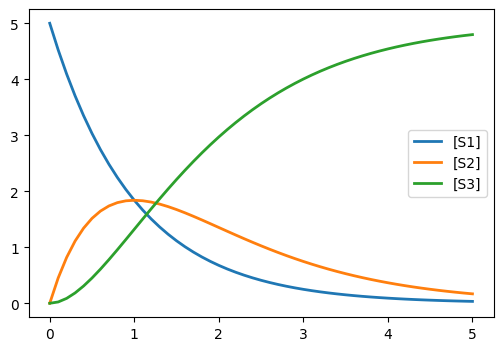

In [4]:
reference_model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 5
S2 = 0
k1 = 1
k2 = 1
"""
rr = te.loada(reference_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

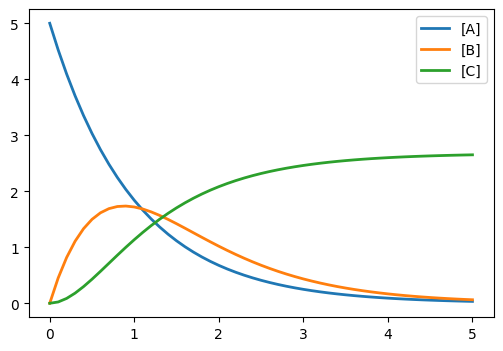

In [5]:
target_model = """
A -> B; k1*A
B -> C; k2*B
B + C -> ; k3*B*C

A = 5
B = 0
k1 = 1
k2 = 1
k3 = 0.2
"""
rr = te.loada(target_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

In [6]:
result = findReferenceInTarget(reference_model, target_model, is_subnet=True, is_report=IS_PLOT)


ssignments: 100%|███████████| 8333330/8333330 [00:00<00:00, 28324569977.57it/s]

In [7]:
result

StructurallyIdenticalResult(assignment_pairs=[species: [0 1 2], reaction: [0 1]]; is_truncated=False;

In [8]:
result.assignment_pairs

[species: [0 1 2], reaction: [0 1]]

In [9]:
result.makeInducedNetwork()

5332946: 3 species, 2 reactions
  _J0: A -> B
  _J1: B -> C

# One-Shot, More Elaborate Example

Here we do subnet discovery of an oscillating network in a model in BioModels.

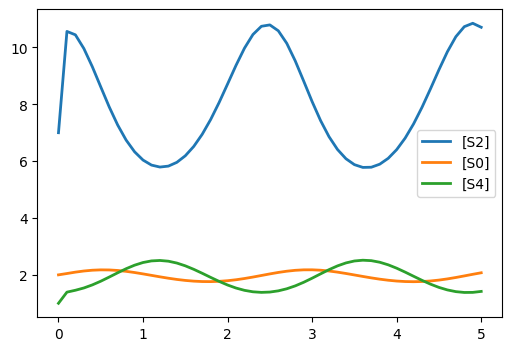

In [10]:
# This is an oscillating network
reference_model = """
J1: $S3 -> S2;  S3*19.3591127845924;
J2: S0 -> S4 + S0;  S0*10.3068257839885;
J3: S4 + S2 -> S4;  S4*S2*13.8915863630362;
J4: S2 -> S0 + S2;  S2*0.113616698747501;
J5: S4 + S0 -> S4;  S4*S0*0.240788980014622;
J6: S2 -> S2 + S2;  S2*1.36258363821544;
J7: S2 + S4 -> S2;  S2*S4*1.37438814584166;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;
"""
rr = te.loada(reference_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

In [11]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1701090001/3/BIOMD0000000695_url.xml"

In [12]:
# This takes about 10 minutes to run on Colab
rr = te.loadSBMLModel(URL)
result = findReferenceInTarget(reference_model, ModelSpecification(rr, specification_type="roadrunner"), is_subnet=True,
        identity=cn.ID_WEAK, is_report=IS_PLOT)

assignments: 100%|██████████| 483927410/483927410 [00:33<00:00, 14241334.44it/s]


We can see all of the mappings of target species to reference speces and target reactions to reference reactions.

In [13]:
len(result.assignment_pairs)

330

We can also see the induced network, a subnet of the target network that is (weakly) structurally identical with the reference network. Note that since we use weak identity, some of the bi-uni reactions in the reference network are assigned to uni-null reactions in the target network.

In [14]:
result.makeInducedNetwork(1)

3522764: 4 species, 7 reactions
  R_31: xFinal_2 -> xFinal_1
  R_10:  -> xFinal_8
  R_33: xFinal_1 + xFinal_8 + xFinal_2 -> xFinal_8 + xFinal_2
  R_24: xFinal_2 -> xFinal_3 + xFinal_2
  R_25: xFinal_3 -> 
  R_32: xFinal_1 + xFinal_8 + xFinal_2 -> 2.0 xFinal_1 + xFinal_8 + xFinal_2
  R_12: xFinal_8 -> 

Note that R_16 is assigned to J3. Note that J3 is a bi-uni reaction, but R_16 is uni-null. This assignment makes sense for weak identity since S4 is a reactant and a product in J3.

# Comparing Directories of Models

``pySubnetSB`` can search for subsets in directories of models. Given a a directory of reference models
and a directory of target models, each target model is searched for each reference model. A "directory" can be a folder in a file system or it can be a file containing a serialization of such a directory (one serialized network per line, as described in the next section). The file can be in the local file system or a URL to a file on the Internet. In the example below, the serializations of references and targets are URLs in the ``github`` repository for ``pySubnetSB``.

A serialization of biomodels is [here](http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/data/biomodels_serialized.txt).

In [15]:
reference_url = "http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/examples/reference_serialized.txt"
target_url = "http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/examples/target_serialized.txt"
result_df = findReferencesInTargets(reference_url, target_url, is_report=IS_PLOT)

Processing reference model: BIOMD0000000031
Found matching model: BIOMD0000000031 and BIOMD0000000170
Processing reference model: BIOMD0000000031


assignments: 100%|██████████| 2083330/2083330 [00:00<00:00, 6716463760.43it/s]


Found matching model: BIOMD0000000031 and BIOMD0000000228
Processing reference model: BIOMD0000000031



ssignments: 100%|███████████| 2083330/2083330 [00:00<00:00, 10578836988.28it/s]

Found matching model: BIOMD0000000031 and BIOMD0000000354
Processing reference model: BIOMD0000000031
Processing reference model: BIOMD0000000027


assignments: 100%|███████████| 2500000/2500000 [00:00<00:00, 17022337662.34it/s]

Found matching model: BIOMD0000000027 and BIOMD0000000170
Processing reference model: BIOMD0000000027



assignments: 100%|██████████| 2500000/2500000 [00:00<00:00, 13090836454.43it/s]


Found matching model: BIOMD0000000027 and BIOMD0000000228
Processing reference model: BIOMD0000000027


assignments: 100%|████████████| 2500000/2500000 [00:00<00:00, 9506582048.96it/s]

Found matching model: BIOMD0000000027 and BIOMD0000000354
Processing reference model: BIOMD0000000027
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121


Found matching model: BIOMD0000000121 and BIOMD0000000960


assignments: 100%|██████████| 1666660/1666660 [00:00<00:00, 7281748650.67it/s]


The output of this method is a dataframe that summarizes subnet discovery.
* reference_name: name of the model in the reference directory
* target_name: name of the model in the target directory
* reference_network: Antimony representation of the complete reference model
* induced_network: Antimony model of the induced network found in the target
* name_dct: dictionary that specifies the species and reaction assignments for the first assignment pair
* num_assignment_pair: number of assignment pairs
* is_truncated: True if the search was truncated because it exceeded the parameter max_num_assignment_pair

In [16]:
result_df

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated
0,BIOMD0000000031,BIOMD0000000170,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","6028312: 6 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",48,False
1,BIOMD0000000031,BIOMD0000000228,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","644208: 6 species, 4 reactions\n pRB_phosphor...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",240,False
2,BIOMD0000000031,BIOMD0000000354,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","1877625: 6 species, 4 reactions\n JChannel: C...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12,False
3,BIOMD0000000031,BIOMD0000000960,,,,,False
4,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","4981549: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24,False
5,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","1136648: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60,False
6,BIOMD0000000027,BIOMD0000000354,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","152159: 5 species, 4 reactions\n JChannel: Ca...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12,False
7,BIOMD0000000027,BIOMD0000000960,,,,,False
8,BIOMD0000000121,BIOMD0000000170,,,,,False
9,BIOMD0000000121,BIOMD0000000228,,,,,False


# Serialize models

You can serialize models to facilitate using ``pySubnetSB``.
This is illustrated in the following cells.

In [17]:
# Clone pySubnetSB to get a directory of files to serialize
!git clone https://github.com/ModelEngineering/pySubnetSB.git

Cloning into 'pySubnetSB'...
remote: Enumerating objects: 3195, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 3195 (delta 100), reused 85 (delta 47), pack-reused 3042 (from 2)
Receiving objects: 100% (3195/3195), 114.45 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (2311/2311), done.


In [18]:
# Establish the paths for serialization. The results will be in the file serialization.txt
cur_dir = os.path.abspath(".")
directory = os.path.join(cur_dir, "pySubnetSB/src/pySubnetSB_tests/xml_files")
serialization_path = os.path.join(cur_dir, "serialization.txt")
makeSerializationFile(directory, serialization_path, is_report=IS_PLOT)

..Done!


In [19]:
# Display the first line of the serialization file. Each network is a separate line. Lines can be appended or deleted.
with open(serialization_path, "r") as fd:
    lines = fd.readlines()
if IS_PLOT:
    lines[0]

In [20]:
# Clean up the cloned repository
!rm -rf pySubnetSB
!ls

api_basics.ipynb         reference_serialized.txt target_serialized.txt
api_basics.py            serialization.txt
